In [1]:
import cuejax as cue 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
emul = cue.Emulator()

# byler_cloudy_grid_emul = cue.Emulator(num_lines=128) # --> default for FSPS

The emulator has some useful attributes to keep in mind. This includes:

- `emul.line_wavelengths`: restframe line wavelengths in AA for all emission lines.
- `emul.cont_wavelengths`: restframe continuum wavelength grid in AA.
- `emul.line_names`: names and wavelengths of all emulated lines
- `emul.free_parameter_order`: assumed order of the theta vector during sampling (NOT the order of parameters as passed to the neural nets)

In [3]:
# default model parameters:
# (this is also the order that the theta vector is assumed to be in 
# when you do emul.predict_lines(theta=theta) or emul.predict_cont(theta=theta))

default_params = {
        'ionspec_index1': 19.7, 
        'ionspec_index2': 5.3, 
        'ionspec_index3': 1.6, 
        'ionspec_index4': 0.6,
        'ionspec_logLratio1': 3.9, 
        'ionspec_logLratio2': 0.01, 
        'ionspec_logLratio3': 0.2,
        'gas_logu': -2.5, 
        'gas_logn': 2,
        'gas_logz': 0., 
        'gas_logno': 0., 
        'gas_logco': 0.,
        'gas_logqion': 49.1, 
        }

Becuase `cuejax` precision is hard-coded to be `jnp.float32`, there are small ($\sim 1$% difference) errors that are introduced when using `cuejax` vs. `cue`.

In [4]:
lines = emul.predict_lines(**default_params).squeeze() # line prediction in Lsun
line_errs = emul.predict_line_err().squeeze() # 1sigma emulation error in Lsun

print('# of lines predicted:',len(lines))
for i,line in enumerate(lines): print(emul.line_names[i],'=',line,'+\-',line_errs[i],'Lsun')

# of lines predicted: 138
H 1 923.150A = 7.6593094 +\- 0.12100999 Lsun
H 1 926.226A = 8.040534 +\- 0.11426168 Lsun
H 1 930.748A = 8.594324 +\- 0.1298033 Lsun
H 1 937.804A = 9.372823 +\- 0.14269021 Lsun
H 1 949.743A = 10.611012 +\- 0.17574975 Lsun
H 1 972.537A = 12.416355 +\- 0.20955294 Lsun
H 1 1025.72A = 15.929629 +\- 0.23181127 Lsun
H 1 1215.67A = 37810.62 +\- 372.03284 Lsun
S 4 1406.02A = 0.06926216 +\- 0.029185714 Lsun
C 4 1548.19A = 6.561012 +\- 9.439734 Lsun
C 4 1550.77A = 4.792404 +\- 6.821803 Lsun
He 2 1640.41A = 5.2312446 +\- 0.083007246 Lsun
O 3 1660.81A = 8.408248 +\- 0.55345744 Lsun
O 3 1666.15A = 24.675247 +\- 1.631071 Lsun
N 3 1750.00A = 14.55875 +\- 1.2150078 Lsun
Ne 3 1814.56A = 1.9457084 +\- 0.14890459 Lsun
Al 3 1854.72A = 10.935661 +\- 0.5429048 Lsun
Al 3 1862.79A = 6.757415 +\- 0.33831224 Lsun
Si 3 1882.71A = 11.241177 +\- 0.8715586 Lsun
Si 3 1892.03A = 7.5322795 +\- 0.51400787 Lsun
C 3 1906.68A = 170.09888 +\- 12.513982 Lsun
C 3 1908.73A = 114.014755 +\- 7.2937946 L

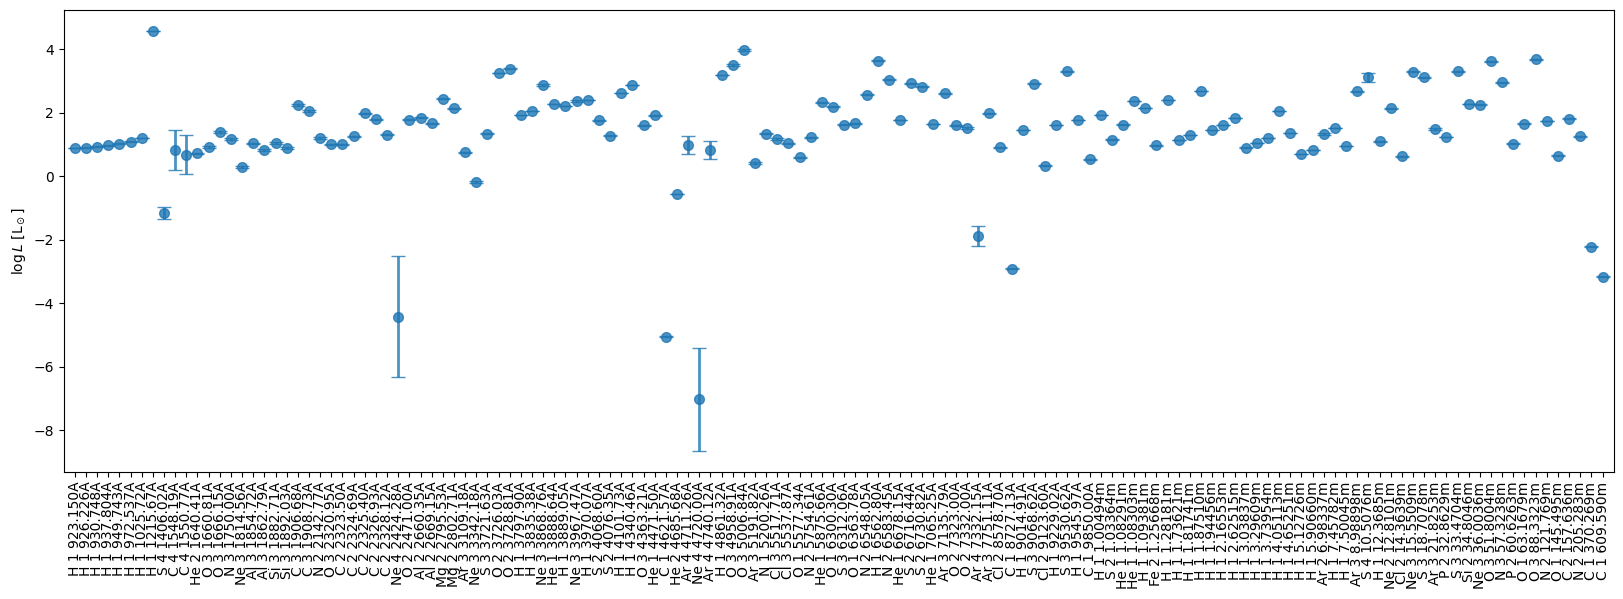

In [5]:
fig,ax = plt.subplots(figsize=(20,6))

log_lines = np.log10(lines)
log_line_errs = line_errs/(np.log(10)*lines)
x = np.arange(len(lines))

ax.errorbar(x,log_lines,yerr=log_line_errs,marker='o',markersize=7,lw=2,capsize=5,linestyle='None',alpha=0.8)
ax.set_xticks(x)
ax.set_xlim(-1,np.max(x)+1)
ax.set_xticklabels(emul.line_names,rotation=90)
ax.set_ylabel(r'$\log L \ [\mathrm{L}_\odot]$')
plt.show()

One of the biggest differences between `cue` and `cuejax` is that the nebular continuum is instead *linearly* interpolated onto the provided wavelength grid, instead of a thrid degree spline. This is purely for computational speed!

In [6]:
wave = np.logspace(3,4,1000) # output wavelength grid for continuum in units of restframe AA (1,000 - 10,000 AA)
# you can also specify unit = 'Lsun/Hz' (default for FSPS) or unit = 'erg/s/Hz' (default for cue)
cont = emul.predict_cont(wave,unit='Lsun/Hz',**default_params).squeeze() 
cont_err = emul.predict_cont_err(wave).squeeze() # 

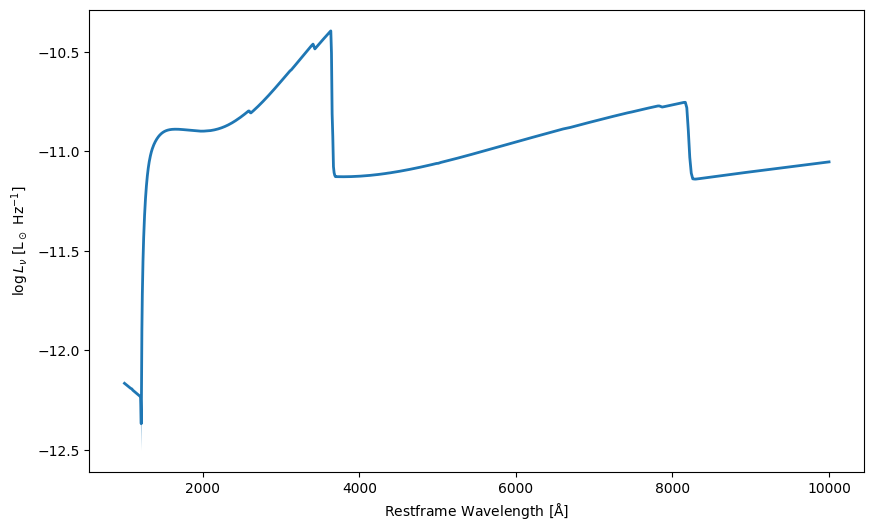

In [7]:
fig,ax = plt.subplots(figsize=(10,6))

log_cont = np.log10(cont)
log_cont_err = cont_err/(np.log(10)*cont)

ax.fill_between(wave,log_cont-log_cont_err,log_cont+log_cont_err,alpha=0.8)
ax.plot(wave,log_cont,lw=2)
ax.set_ylabel(r'$\log L_\nu \ [\mathrm{L_\odot \ Hz^{-1}}]$')
ax.set_xlabel(r'Restframe Wavelength [$\mathrm{\AA}$]')
plt.show()

# JIT-compiling cuejax

You may have noticed that the above functions run a bit slower than you might expect for `cue`. In fact, let's test it!

In [8]:
theta = np.array(list(default_params.values())) # this would be proposed by a sampler

def slow_line_prediction(x,emul):
    lines = emul.predict_lines(theta=x).squeeze()
    line_errs = emul.predict_line_err().squeeze()
    return lines, line_errs

def slow_cont_prediction(x,emul):
    cont = emul.predict_cont(wave,theta=x).squeeze()
    cont_err = emul.predict_cont_err(wave).squeeze()
    return cont, cont_err

In [9]:
%timeit slow_line_prediction(theta,emul)

22.6 ms ± 118 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit slow_cont_prediction(theta,emul)

6.9 ms ± 95.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For the lines, `cuejax` is ~20x slower than cue, and the continuum is ~10x slower! This is due for a lot of under-the-hood reasons, such as the differences in compilation in JAX by itself versus Tensorflow/Scikitlearn.

We can instead use the JIT-compiled version of `cuejax`, which is accessed through the `fast_line_prediction` and `fast_cont_prediction` functions. This makes `cuejax` a bit more comparable to `cue`. However, it's important to note that these functions are designed to be handled by a sampler during a model fit, where the theta vector is the only input (and you cannot adjust the model attributes after compiling these functions).

Let's test it:

In [11]:
from cuejax.emulator import fast_line_prediction, fast_cont_prediction

# you should let these models compile for benchmarking them!!!
_ = fast_line_prediction(theta,emul)
_ = fast_cont_prediction(theta,wave,emul,unit='Lsun/Hz')

In [12]:
# around 10x faster than cue on a CPU
%timeit lines, line_errs = fast_line_prediction(theta,emul)

384 μs ± 533 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# around 4x faster than cue on a CPU
%timeit cont, cont_err = fast_cont_prediction(theta,wave,emul)

31.5 μs ± 16.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
